# BenzDB tools

## Preamble
This notebook provides access to some of the data in the BenzDB database. This database provides a certain amount of information on benzenoids composed of up to 9 fused cycles. More details about the database can be found at [https://benzenoids.lis-lab.fr/](https://benzenoids.lis-lab.fr/).

To use this notebook, simply execute each of the cells. The last cell offers a form that allows you to :
* select the benzenoids you want using different criteria
* choose a query from the various queries offered by BenzDB,
* retrieve data from the database,
* present the results either globally or molecule by molecule.

Information can be saved in json or xlsx format.

## Source code

### Module imports

In [1]:
import ipywidgets as w
import requests
import json
import base64 
import io
from PIL import Image
import IPython as ip
import jupyter_jsmol as Jsmol
import pandas as pd
import matplotlib.pyplot as plt

### Definition of criterion classes

#### Definition of the main criterion class

In [2]:
class Criterion:
    """ This class allows for representing criterions """
    
    def __init__ (self, key: str, description: str):
        """ initializes the criterion """
        self.__key = key
        self.__description  = description     
    
    
    def display (self):
        """ displays the widget corresponding to the criterion """
        pass
    
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        pass
    
    
    def get_description (self) -> str:
        """ returns the description """
        return self.__description
    
    
    def get_key (self) -> str:
        """ returns the key related to the criterion """
        return self.__key
    
    
    def set_widget (self, w) -> None:
        """ sets the widget """
        self.__widget = w
    
    
    def get_widget (self):
        return self.__widget

#### Definition of criterion child classes

In [3]:
class Int_Criterion (Criterion):
    """ This class allows for representing criterions based on int value """
 
    def __init__ (self, key: str, description: str, min_value: int, max_value: int):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.BoundedIntText(value=min_value, min=min_value, max=max_value)
        self.__condition = w.Select(description=self.get_description(), options=["not set","=","<>","<=","<",">",">="], value='not set', rows=1, layout={"width": "auto"})
        
        self.__element.layout.width = "5em"
        self.__condition.layout.width = "13em"
        
        self.set_widget(w.HBox([self.__condition, self.__element]))
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "' + self.__condition.value + " " + str(self.__element.value) + '"'

In [4]:
class Boolean_Criterion (Criterion):
    """ This class allows for representing criterions based on Boolean value """
 
    def __init__ (self, key: str, description: str):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.BoundedIntText(value=1, min=0, max=1, layout={"width": "3.5em"})
        self.__condition = w.Select(description=self.get_description(), options=["not set","="], value='not set', rows=1)#, style={"description width": "8em"})
        
        self.__element.layout.width = "3em"
        self.__condition.layout.width = "15em"
        self.__condition.style.description_width = "10em"
                
        self.set_widget(w.HBox([self.__condition, self.__element]))
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "' + self.__condition.value + " " + str(self.__element.value) + '"'

In [5]:
class Float_Criterion (Criterion):
    """ This class allows for representing criterions based on float value """
 
    def __init__ (self, key: str, description: str, min_value: float, max_value: float):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.BoundedFloatText(value=min_value, min=min_value, max=max_value, layout={"width": "auto"})
        self.__condition = w.Select(description=self.get_description(), options=["not set","=","<>","<=","<",">",">="], value='not set', rows=1, layout={"width": "auto"})
        
        self.__element.layout.width = "5em"
        self.__condition.layout.width = "13em"
        
        self.set_widget(w.HBox([self.__condition, self.__element]))
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "' + self.__condition.value + " " + str(self.__element.value) + '"'

In [6]:
 class Interval_Criterion (Criterion):
    """ This class allows for representing criterions based on float value """
 
    def __init__ (self, key: str, description: str, min_value: float, max_value: float):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element1 =  w.BoundedFloatText(value=min_value, min=min_value, max=max_value, layout={"width": "auto"})
        self.__element2 =  w.BoundedFloatText(value=min_value, min=min_value, max=max_value, layout={"width": "auto"})
        self.__condition = w.Select(description=self.get_description(), options=["not set","in"], value='not set', rows=1, layout={"width": "auto"})
        
        self.__element1.layout.width = '5em'
        self.__element2.layout.width = '5em'
        self.__condition.layout.width = '12em'
        
        self.set_widget(w.HBox([self.__condition, self.__element1, self.__element2]))
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "IN ' + str(self.__element1.value) + " " + str(self.__element2.value) + '"'

In [7]:
 class Int_Interval_Criterion (Criterion):
    """ This class allows for representing criterions based on int value """

    def __init__ (self, key: str, description: str, min_value: float, max_value: float):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element1 =  w.BoundedIntText(value=min_value, min=min_value, max=max_value, layout={"width": "auto"})
        self.__element2 =  w.BoundedIntText(value=min_value, min=min_value, max=max_value, layout={"width": "auto"})
        self.__condition = w.Select(description=self.get_description(), options=["not set","in"], value='not set', rows=1, layout={"width": "auto"})
        
        self.__element1.layout.width = '5em'
        self.__element2.layout.width = '5em'
        self.__condition.layout.width = '12em'
        
        self.set_widget(w.HBox([self.__condition, self.__element1, self.__element2]))
 

    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "IN ' + str(int(self.__element1.value)) + " " + str(int(self.__element2.value)) + '"'

In [8]:
class String_Criterion (Criterion):
    """ This class allows for representing criterions based on string value """
 
    def __init__ (self, key: str, description: str):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.Text(layout={"width": "auto"})
        self.__condition = w.Select(description=self.get_description(), options=["not set","=","<>"], value='not set', rows=1)
        
        self.__element.layout.width = "15em"
        self.__condition.layout.width = "13em"
        
        self.set_widget(w.HBox([self.__condition, self.__element]))
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "' + self.__condition.value + " " + str(self.__element.value) + '"'

In [9]:
class Item_Criterion (Criterion):
    """ This class allows for representing criterions based on list of values """
 
    def __init__ (self, key: str, description: str, values: list):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.Select(options=values, description="", disabled=False,rows=1)
        self.__condition = w.Select(description=self.get_description(), options=["not set","=","<>"], value='not set', rows=1)
        
        self.__element.layout.width = "5em"
        self.__condition.layout.width = "13em"
        
        self.set_widget(w.HBox([self.__condition, self.__element]))
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        if self.__condition.value == "not set":
            return ""
        else:
            return '"' + self.get_key() + '": "' + self.__condition.value + " " + str(self.__element.value) + '"'

In [10]:
class Query_Criterion (Criterion):
    """ This class allows for representing the desired query """
 
    def __init__ (self, key: str, description: str):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.Select(description=self.get_description(), options=["benzenoids","ir","ims2d1a","nics","clar_covers","properties","irregularities","patterns"], value='benzenoids', rows=1, layout={"width": "auto"})
                
        self.set_widget(w.HBox([self.__element]))
        
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        return str(self.__element.value)

In [11]:
class View_Criterion (Criterion):
    """ This class allows for representing the desired view """
 
    def __init__ (self, key: str, description: str):
        """ initializes the criterion """
        super().__init__(key, description)
        
        self.__element =  w.Select(description=self.get_description(), options=["global","one by one"], value='global', rows=1, layout={"width": "auto"})
                
        self.set_widget(w.HBox([self.__element]))
           
    
    def get_criterion (self) -> str:
        """ returns the JSON string corresponding to the criterion, an empty string if the criterion is not set """
        return str(self.__element.value)

### Definition of the display classes

In [12]:
class Display:
    """ This class allows for displaying benzenoid information """
    
    def __init__ (self, info: dict):
        """ initializes the display tool """
        self.__information = info
        self.__data = {}
        self.add_data ("Benzenoid id", self.get_information("idBenzenoid"))
        self.add_data ("InChI", self.get_information("inchi"))
        self.add_data ("Label", self.get_information("label"))
        self.add_data ("#hexagons", self.get_information("nbHexagons"))
        self.add_data ("#carbons", self.get_information("nbCarbons"))
        self.add_data ("#hydrogens", self.get_information("nbHydrogens"))
        self.add_data ("Weight", self.get_information("weight"))
        self.add_data ("Irregularity", self.get_information("irregularity"))
        self.add_data ("Diameter", self.get_information("diameter"))
    
    
    def add_data (self, label, value) -> None:
        """ adds a label to display with its corresponding value """
        self.__data [label] = [value]
        
    
    def display (self) -> None:
        """ displays the information """           
        self.__df = pd.DataFrame(self.__data)
        self.__df.index = [""]
        
        ip.display.display(self.__df.transpose())
        self.display_molecule()
        
    
    def display_molecule (self) -> None:
        """ displays the molecule thanks to Jsmol """
        view = Jsmol.JsmolView.from_str(str(self.get_information("nbCarbons")+self.get_information("nbHydrogens"))+"\nComment\n"+self.get_information("geometry"))
        ip.display.display(view)
        
    
    def display_image (self, str64: str) -> None:
        """ displays the base-64 image defined by str64 """
        img = Image.open(io.BytesIO(base64.b64decode(str64)))
        ip.display.display(img)
        
    
    def get_information (self, key) -> dict:
        """ returns the information """
        return self.__information[key]

In [13]:
class Display_IR (Display):
    """ This class allows for displaying benzenoid information from IR query """

    def __init__ (self, info: dict):
        """ initializes the display tool """
        super().__init__(info)
        self.add_data ("Final energy", self.get_information("finalEnergy"))
        self.add_data ("Zero Point Energy", self.get_information("zeroPointEnergy"))
        
    
    def display (self) -> None:
        """ displays the information """
        super().display()
               
        x = [float(v) for v in self.get_information("frequencies").split(" ")]
        y = [float(v) for v in self.get_information("intensities").split(" ")]
        
        plt.cla()
        plt.stem(x, y, linefmt='-', markerfmt="")
        plt.xlabel('frequencies ($cm^{-1}$)')
        plt.ylabel('intensities ($km.mol^{-1}$)')
        plt.show()
        download_button("AMES", "ames.xml", self.get_information("amesFormat"))

In [14]:
class Display_IMS2D1A (Display):
    """ This class allows for displaying benzenoid information from IMS2D1A query """

    def __init__ (self, info: dict):
        """ initializes the display tool """
        super().__init__(info)
        self.add_data ("Type", self.get_information("type"))

    def display (self) -> None:
        """ displays the information """
        super().display()
        self.display_image(self.get_information("picture"))

In [15]:
class Display_NICS (Display):
    """ This class allows for displaying benzenoid information from NICS query """
    def __init__ (self, info: dict):
        """ initializes the display tool """
        super().__init__(info)
        self.add_data ("NICS R values", self.get_information("nicsR"))
        self.add_data ("NICS U values", self.get_information("nicsU"))

In [16]:
class Display_Clar_Covers (Display):
    """ This class allows for displaying benzenoid information from Clar Cover query """
    
    def display (self) -> None:
        """ displays the information """
        super().display()
        self.display_image(self.get_information("clarCover"))

In [17]:
class Display_Properties (Display):
    """ This class allows for displaying benzenoid information from properties query """

    def __init__ (self, info: dict):
        """ initializes the display tool """
        super().__init__(info)
        yesno = ["no","yes"]
        self.add_data ("Catacondensed", yesno[self.get_information("catacondensed")])
        self.add_data ("Coronoid", yesno[self.get_information("coronoid")])
        self.add_data ("Coronenoid", yesno[self.get_information("coronenoid")])
        self.add_data ("Symmetry 2D", self.get_information("symmetry2D"))
        self.add_data ("Symmetry 3D", self.get_information("symmetry3D"))
        self.add_data ("#Kekulé structures", self.get_information("kekule"))
        self.add_data ("Clar number", self.get_information("clarNumber"))
        self.add_data ("HOMO", self.get_information("homo"))
        self.add_data ("LUMO", self.get_information("lumo"))
        self.add_data ("Gap", self.get_information("lumo") - self.get_information("homo"))
        self.add_data ("Total energy", self.get_information("finalEnergy"))
        self.add_data ("Zero point energy", self.get_information("zeroPointEnergy"))
        self.add_data ("Dipole moment", self.get_information("moment"))
        self.add_data ("Planar", yesno[self.get_information("planar")])

In [18]:
class Display_Irregularities (Display):
    """ This class allows for displaying benzenoid information from irregularities query """
    
    def __init__ (self, info: dict):
        """ initializes the display tool """
        super().__init__(info)
        self.add_data ("# solo", self.get_information("solo"))
        self.add_data ("# duo", self.get_information("duo"))
        self.add_data ("# trio", self.get_information("trio"))
        self.add_data ("# quartet", self.get_information("quartet"))        

In [19]:
class Display_Patterns (Display):
    """ This class allows for displaying benzenoid information from patterns query """
    
    def __init__ (self, info: dict):
        """ initializes the display tool """
        super().__init__(info)
        self.add_data ("cove", self.get_information("cove"))
        self.add_data ("fjord", self.get_information("fjord"))

### Definition of the table classes

In [20]:
class Table:
    """ This class allows for displaying a table containing benzenoid information """
    
    def __init__ (self):
        """ initializes the display tool """
        self.__data = {}
    
    
    def add_data (self, label, value) -> None:
        """ adds a label to display with its corresponding value """
        if label not in self.__data:
            self.__data[label] = []
        self.__data [label] += [value]
        
    
    def add_row (self, info: dict) -> None:
        """ adds a row based on the given information """           
        self.add_data ("Benzenoid id", info["idBenzenoid"])
        self.add_data ("InChI", info["inchi"])
        self.add_data ("Label", info["label"])
        self.add_data ("#hexagons", info["nbHexagons"])
        self.add_data ("#carbons", info["nbCarbons"])
        self.add_data ("#hydrogens", info["nbHydrogens"])
        self.add_data ("Weight", info["weight"])
        self.add_data ("Irregularity", info["irregularity"])
        self.add_data ("Diameter", info["diameter"])
        
        
    def print (self):
        """ prints the table """
        self.__df = pd.DataFrame(self.__data)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        ip.display.display(self.__df)
    
    
    def save (self, filename):
        """ saves the data as a xlsx/ods file """
        df = pd.DataFrame(self.__data)
        with pd.ExcelWriter(filename) as writer:
            df.to_excel(writer,sheet_name="result",index=False, header=True)

            # format definitions
            workbook  = writer.book
            format_column_title = workbook.add_format({'num_format': '@', 'align': 'center', 'bold': True})
            sheet = writer.sheets["result"]
            sheet.set_row(0, None,format_column_title)
            sheet.freeze_panes(0, 1)
            sheet.autofit()

In [21]:
class Table_IR (Table):
    """ This class allows for displaying a table containing benzenoid information from ir query """

    def add_row (self, info: dict) -> None:
        """ adds a row based on the given information """
        super().add_row (info)
        yesno = ["no","yes"]
        self.add_data ("final energy", info["finalEnergy"])
        self.add_data ("ZPE", info["zeroPointEnergy"])

In [22]:
class Table_Properties (Table):
    """ This class allows for displaying a table containing benzenoid information from properties query """

    def add_row (self, info: dict) -> None:
        """ adds a row based on the given information """
        super().add_row (info)
        
        yesno = ["no","yes"]
        self.add_data ("Catacondensed", yesno[info["catacondensed"]])
        self.add_data ("Coronoid", yesno[info["coronoid"]])
        self.add_data ("Coronenoid", yesno[info["coronenoid"]])
        self.add_data ("Symmetry 2D", info["symmetry2D"])
        self.add_data ("Symmetry 3D", info["symmetry3D"])
        self.add_data ("#Kekulé structures", info["kekule"])
        self.add_data ("Clar number", info["clarNumber"])
        self.add_data ("HOMO", info["homo"])
        self.add_data ("LUMO", info["lumo"])
        self.add_data ("Gap", info["lumo"]-info["homo"])
        self.add_data ("Total energy", info["finalEnergy"])
        self.add_data ("Zero point energy", info["zeroPointEnergy"])
        self.add_data ("Dipole moment", info["moment"])
        self.add_data ("Planar", yesno[info["planar"]])
        

In [23]:
class Table_Irregularities (Table):
    """ This class allows for displaying a table containing benzenoid information from irregularities query """
    
    def add_row (self, info: dict) -> None:
        """ adds a row based on the given information """
        super().add_row (info)
        self.add_data ("# solo", info["solo"])
        self.add_data ("# duo", info["duo"])
        self.add_data ("# trio", info["trio"])
        self.add_data ("# quartet", info["quartet"])
        

In [24]:
class Table_Patterns (Table):
    """ This class allows for displaying a table containing benzenoid information from patterns query """

    def add_row (self, info: dict) -> None:
        """ adds a row based on the given information """
        super().add_row (info)
        self.add_data ("cove", info["cove"])
        self.add_data ("fjord", info["fjord"])

### Definition of the form class

In [25]:
def download_button (label: str, filename: str, data: str) -> None:
    """ prints a download button """
    # we encode the data
    encoded_data = base64.b64encode(data.encode()).decode()
    
    # we create the download button
    button = '''<html>
    <body>
    <a download="'''+filename+'''" href="data:text/'''+filename.split(".")[1]+''';base64,'''+encoded_data+'''">
    <button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning">Download '''+label+''' file</button>
    </a>
    </body>
    </html>
    '''
    
    ip.display.display(w.HTML(button))

    
def download_button_xlsx (label: str, filename: str, data) -> None:
    """ prints a download button """
    # we save the data
    data.save(filename)
    
    # we create the download button
    button = '''<html>
    <body>
    <a download="'''+filename+'''" href="'''+filename+'''">
    <button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning">Download '''+label+''' file</button>
    </a>
    </body>
    </html>
    '''
    
    ip.display.display(w.HTML(button))

    
def process (form):    
    demand_type = form.get_demand_type()

    if demand_type == "data":
        data = form.get_data()
        query = form.get_query()
        view = form.get_view()
        
        if view == "global":
            if query == "properties":
                d = Table_Properties()
                data = sorted(data, key=lambda t: (t["nbHexagons"],t["symmetry3D"],t["lumo"]-t["homo"]))
            elif query == "irregularities":
                d = Table_Irregularities()
            elif query == "ir":
                d = Table_IR()    
            elif query == "patterns":
                d = Table_Patterns()
            else:
                d = Table()
            for molecule in data:
                d.add_row (molecule)
            
            download_button_xlsx("XLSX", query+".xlsx",d)
            d.print()
        elif view == "one by one":
            for molecule in data:
                if query == "benzenoids":
                    d = Display(molecule)
                elif query == "ir":
                    d = Display_IR(molecule)
                elif query == "ims2d1a":
                    d = Display_IMS2D1A(molecule)
                elif query == "nics":
                    d = Display_NICS(molecule)
                elif query == "clar_covers":
                    d = Display_Clar_Covers(molecule)
                elif query == "properties":
                    d = Display_Properties(molecule)
                elif query == "irregularities":
                    d = Display_Irregularities(molecule)
                elif query == "patterns":
                    d = Display_Patterns(molecule)
                d.display()

    elif demand_type == "count":
        print ("Number of molecules:",form.get_data())

    elif demand_type == "json":
        download_button("JSON", "query.json", form.get_json_string())
        print ("JSON query:")
        print (form.get_json_string())
        
    elif demand_type == "result":
        download_button("JSON", "result.json", str(form.get_data()).replace("'",'"'))
        print ("JSON result (100,000 first characters):")
        print (str(form.get_data())[0:100_000].replace("'",'"'))

In [26]:
class Form:
    
    def __init__ (self):
        """ initialise the form """
        self.__query = None         # the query
        self.__demand_type = None   # the type of demand
        self.__json_string = None   # the query as a JSON string
        self.__data = None          # the data related to the query (if the query succeeds)
        
        self.create_form()
        
        
    def create_form(self) -> None:
        """ creates the form allowing for choosing the values of desired criteria """
        self.__criteria = []

        # criteria about basic information
        self.__criteria.append (Int_Criterion(key="idBenzenoid", description="BenzDB id", min_value=0, max_value=8391))
        self.__criteria.append (String_Criterion(key="inchi", description="InChI"))
        self.__criteria.append (String_Criterion(key="label", description="BenzAI label"))
        
        self.__criteria.append (Int_Criterion(key="nbHexagons", description="# hexagons", min_value=1, max_value=9))
        self.__criteria.append (Int_Criterion(key="nbCarbons", description="# carbons", min_value=6, max_value=38))
        self.__criteria.append (Int_Criterion(key="nbHydrogens", description="# hydrogens", min_value=6, max_value=22))
                
        self.__criteria.append (Int_Criterion(key="solo", description="# solo", min_value=0, max_value=14))
        self.__criteria.append (Int_Criterion(key="duo", description="# duo", min_value=0, max_value=14))
        self.__criteria.append (Int_Criterion(key="trio", description="# trio", min_value=0, max_value=18))
        self.__criteria.append (Int_Criterion(key="quartet", description="# quartet", min_value=0, max_value=20))
        self.__criteria.append (Float_Criterion(key="irregularity", description="Irregularity", min_value=0, max_value=1))
        
        self.__criteria.append (Int_Criterion(key="kekule", description="# structures", min_value=0, max_value=110))
        self.__criteria.append (Int_Criterion(key="clarNumber", description="Clar number", min_value=0, max_value=6))
        
        self.__criteria.append (Boolean_Criterion(key="catacondensed", description="Is catacondensed"))
        self.__criteria.append (Boolean_Criterion(key="coronenoid", description="Is coronenoid"))
        self.__criteria.append (Boolean_Criterion(key="coronoid", description="Is coronoid"))
        self.__criteria.append (Boolean_Criterion(key="planar", description="Is planar"))
        self.__criteria.append (Int_Criterion(key="diameter", description="Diameter", min_value=0, max_value=8))
        
        self.__criteria.append (Interval_Criterion(key="frequency", description="Frequency", min_value=0, max_value=3466))
        self.__criteria.append (Interval_Criterion(key="intensity", description="Intensity", min_value=0, max_value=2742))
        
        self.__criteria.append (Item_Criterion(key="symmetry2D", description="Symmetry 2D", values=["Cs","C2hi","C2hii","C3hi","C3hii","C2va","C2vb","D2hi","D2hii","D3hia","D3hii","D6h"]))
        self.__criteria.append (Item_Criterion(key="symmetry3D", description="Symmetry 3D", values=["C1","Ci","Cs","C2","C2v","C2h","C3","C3h","D2","D2h","D3h","D6h"]))

        self.__criteria.append (Int_Interval_Criterion(key="cove", description="#coves", min_value=0, max_value=4))
        self.__criteria.append (Int_Interval_Criterion(key="fjord", description="#fjords", min_value=0, max_value=2))
        
        # definition of groups of widgets
        self.add_group ([self.__criteria[0:1],self.__criteria[1:3]], "Molecule identity")
        self.add_group ([self.__criteria[3:6]], "Basic features")
        self.add_group ([self.__criteria[6:10],self.__criteria[10:11]],"Irregularity features")
        self.add_group ([self.__criteria[11:13]],"Kekulé structures and Clar number")
        self.add_group ([self.__criteria[13:15],self.__criteria[15:18]],"Structural properties")
        self.add_group ([self.__criteria[18:20]],"IR features")
        self.add_group ([self.__criteria[20:22]],"Symmetry properties")
        self.add_group ([self.__criteria[22:24]],"Patterns")
        
        # query
        self.__criteria.append (Query_Criterion(key="query", description="query"))
        
        # type of view
        self.__criteria.append (View_Criterion(key="view", description="View type"))

        # validation buttons
        count_btn = w.Button (description="Count")
        count_btn.on_click (self.perform_query)

        getdata_btn = w.Button (description="Get Data")
        getdata_btn.on_click (self.perform_query)

        getquery_btn = w.Button (description="Get JSON Query")
        getquery_btn.on_click (self.perform_query)
        
        getresult_btn = w.Button (description="Get JSON Result")
        getresult_btn.on_click (self.perform_query)
        
        self.add_group([self.__criteria[24:26],[count_btn, getdata_btn, getquery_btn, getresult_btn]],"Query choices")
    
    
    def perform_query (self, btn) -> None:
        """ performs the query and sets the corresponding attributes """ 
        # we identify the type of demand
        if btn.description == "Count":
            self.__demand_type = "count"
        elif btn.description == "Get Data":
            self.__demand_type = "data"
        elif btn.description == "Get JSON Query":
            self.__demand_type = "json"
        elif btn.description == "Get JSON Result":
            self.__demand_type = "result"
        else:
            self.__demand_type = "unknown"

        # we build the JSON string
        self.__json_string = "{\n"
        for c in self.__criteria:
            if isinstance(c,Query_Criterion):
                self.__query = c.get_criterion()
            elif isinstance(c,View_Criterion):
                self.__view = c.get_criterion()
            else:
                s = c.get_criterion()
                if len(s) > 0:
                    if len(self.__json_string) > 3:
                        self.__json_string += ",\n"
                    self.__json_string += "\t" + s
        self.__json_string += "\n}"

        if self.__demand_type in ["data", "result"]:
            response = requests.post("https://benzenoids.lis-lab.fr/find_"+self.__query, json= json.loads(self.__json_string))    
        elif self.__demand_type == "count":
            response = requests.post("https://benzenoids.lis-lab.fr/count_"+self.__query, json= json.loads(self.__json_string))
        
        if self.__demand_type in ["data", "count", "result"]:
            if response.status_code == 200:
                self.__data = response.json()
                
        process(self)

        
    def add_group (self, criteria:list, title: str) -> None:
        """ defines a group of widgets from the given list of criteria """
        title_box = w.HTML(value="<b>"+title+"</b>")
        display(title_box)

        for l in criteria:
            box = w.HBox([c.get_widget() if isinstance(c,Criterion) else c for c in l])
            display(box)
        
        
    def get_data (self):
        """ returns the data related to the query """
        return self.__data
    
    
    def get_query (self):
        """ returns the desired query """
        return self.__query

    
    def get_json_string (self):
        """ returns the JSON string related to the desired query """
        return self.__json_string
    

    def get_demand_type (self):
        """ returns the type of the current demand """
        return self.__demand_type
    
    
    def get_view (self):
        """ returns the desired type of view """
        return self.__view

## Filling the form

HTML(value='<b>Molecule identity</b>')

HTML(value='<b>Basic features</b>')

HTML(value='<b>Irregularity features</b>')

HTML(value='<b>Kekulé structures and Clar number</b>')

HTML(value='<b>Structural properties</b>')

HTML(value='<b>IR features</b>')

HTML(value='<b>Symmetry properties</b>')

HTML(value='<b>Patterns</b>')

HTML(value='<b>Query choices</b>')

,
Benzenoid id,3532
InChI,1S/C14H10/c1-3-7-13-11(5-1)9-10-12-6-2-4-8-14(...
Label,1-3-4
#hexagons,3
#carbons,14
#hydrogens,10
Weight,178.22976
Irregularity,0.8
Diameter,2
NICS R values,-8.5103 -8.5103 -5.4976


JsmolView(layout=Layout(align_self='stretch', height='400px'))

,
Benzenoid id,4421
InChI,1S/C14H10/c1-2-6-12-10-14-8-4-3-7-13(14)9-11(1...
Label,0-4-8
#hexagons,3
#carbons,14
#hydrogens,10
Weight,178.22976
Irregularity,0.8
Diameter,2
NICS R values,-7.4113 -11.2045 -7.4113


JsmolView(layout=Layout(align_self='stretch', height='400px'))

,
Benzenoid id,4674
InChI,1S/C13H22/c1-4-10-6-2-8-12-9-3-7-11(5-1)13(10)...
Label,0-3-4
#hexagons,3
#carbons,13
#hydrogens,9
Weight,165.21108
Irregularity,1.0
Diameter,1
NICS R values,-2.607 -2.607 -2.6032


JsmolView(layout=Layout(align_self='stretch', height='400px'))

,
Benzenoid id,3532
InChI,1S/C14H10/c1-3-7-13-11(5-1)9-10-12-6-2-4-8-14(...
Label,1-3-4
#hexagons,3
#carbons,14
#hydrogens,10
Weight,178.22976
Irregularity,0.8
Diameter,2
Type,U


JsmolView(layout=Layout(align_self='stretch', height='400px'))

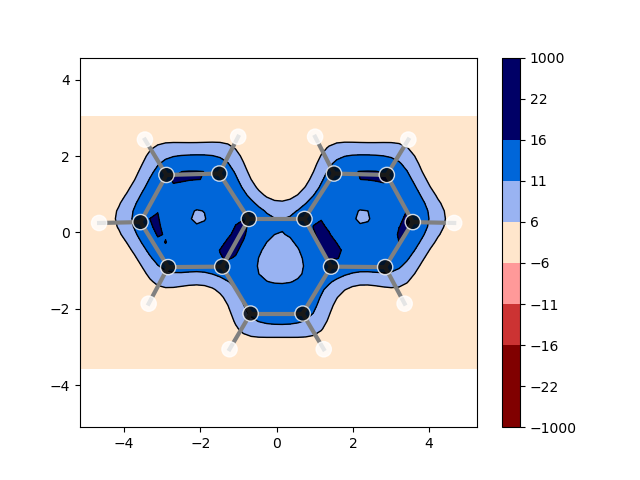

,
Benzenoid id,3532
InChI,1S/C14H10/c1-3-7-13-11(5-1)9-10-12-6-2-4-8-14(...
Label,1-3-4
#hexagons,3
#carbons,14
#hydrogens,10
Weight,178.22976
Irregularity,0.8
Diameter,2
Type,R


JsmolView(layout=Layout(align_self='stretch', height='400px'))

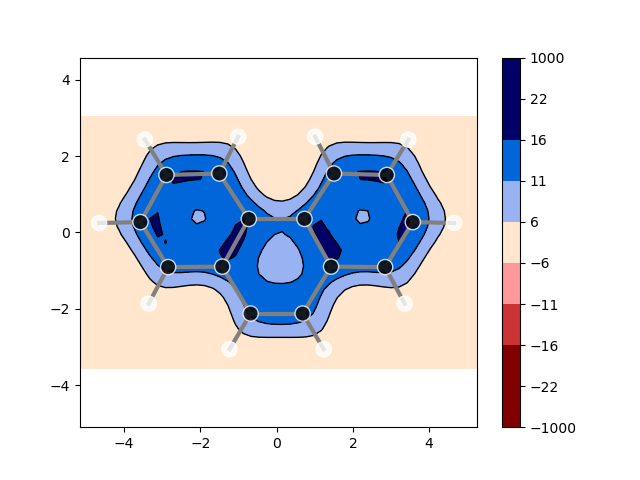

,
Benzenoid id,4421
InChI,1S/C14H10/c1-2-6-12-10-14-8-4-3-7-13(14)9-11(1...
Label,0-4-8
#hexagons,3
#carbons,14
#hydrogens,10
Weight,178.22976
Irregularity,0.8
Diameter,2
Type,U


JsmolView(layout=Layout(align_self='stretch', height='400px'))

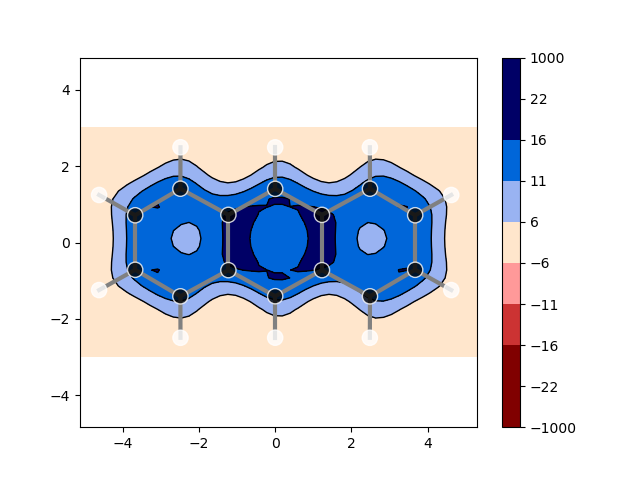

,
Benzenoid id,4421
InChI,1S/C14H10/c1-2-6-12-10-14-8-4-3-7-13(14)9-11(1...
Label,0-4-8
#hexagons,3
#carbons,14
#hydrogens,10
Weight,178.22976
Irregularity,0.8
Diameter,2
Type,R


JsmolView(layout=Layout(align_self='stretch', height='400px'))

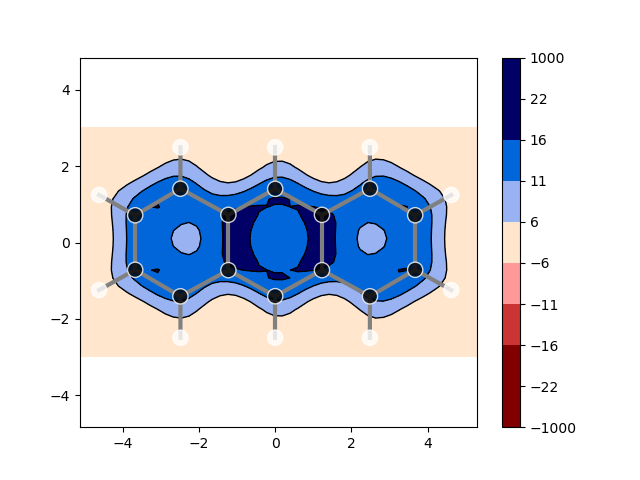

,
Benzenoid id,4674
InChI,1S/C13H22/c1-4-10-6-2-8-12-9-3-7-11(5-1)13(10)...
Label,0-3-4
#hexagons,3
#carbons,13
#hydrogens,9
Weight,165.21108
Irregularity,1.0
Diameter,1
Type,U


JsmolView(layout=Layout(align_self='stretch', height='400px'))

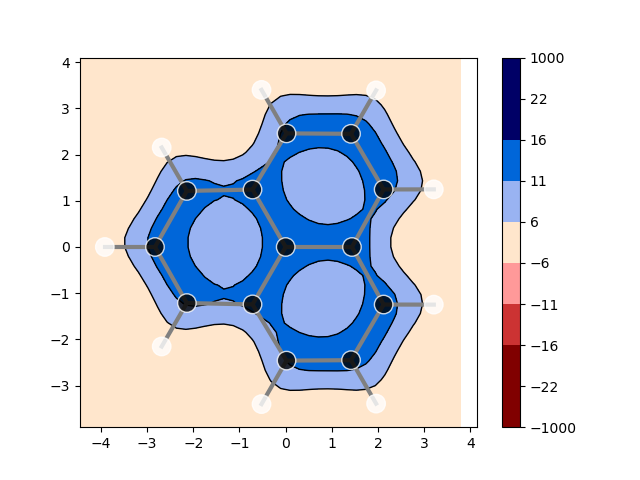

In [27]:
form = Form()